# Demo of a simple futures trend following strategy

Load modules. The heavy-lifting is done by `futures.py`

In [12]:
import datetime, os, sys, itertools, re, math

import numpy as np
import pandas as pd
pd.options.display.max_rows = 500
import matplotlib.pyplot as plt

import importlib
import futures

meta = futures.meta

In [13]:
risk_factor = 0.002
equity = 1000000

data_start = 2003
data_end = 2016
day_first_position = "2004-01-01"
symbols = list(futures.ready_meta(data_start)['Quandl Symbol'])

df = futures.load_continuous_future(symbols, start_year=data_start, end_year=data_end, method="backward")
df.columns = pd.MultiIndex.from_tuples( list(itertools.product(symbols, ['price'])) )

# if any one of the symbol misses a day, remove that day for all the symbols
df.dropna(how='any', inplace=True)

#### Currently we have metadata on 41 instruments. Here's a sample:

In [14]:
meta[["Contract","Quandl Symbol","Minimum Fluctuation","Currency","point_value"]].head()

,Contract,Quandl Symbol,Minimum Fluctuation,Currency,point_value
0,Dollar Index,ICE/DX,.005 = $5.00,USD,1000.0
1,Australian Dollar,CME/AD,1 = $10.00,USD,100000.0
2,British Pound,CME/BP,1 = $6.25,USD,62500.0
3,Canadian Dollar,CME/CD,1 = $10.00,USD,100000.0
4,Euro FX,CME/EC,1 = $12.50,USD,125000.0


#### Here's what our main data structure looks after the contracts adjustments:

In [15]:
df.tail()

,ICE/DX,CME/AD,CME/BP,CME/CD,CME/EC,CME/SF,CME/JY,CME/SP,CME/US,CME/TY,...,EUREX/FGBM,EUREX/FGBS,LIFFE/Z,LIFFE/R,CME/PA,CME/PL,CME/NK,CME/LB,CME/RR,CME/NE
,price,price,price,price,price,price,price,price,price,price,...,price,price,price,price,price,price,price,price,price,price
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,103.002,0.7156,1.2299,0.73940,1.04910,0.9786,8563.5,2260.0,149.12500,123.359375,...,133.45,112.295,7004.0,124.60,654.85,895.0,19460.0,318.6,9.460,0.6852
2016-12-27,103.007,0.7172,1.2300,0.73760,1.05015,0.9780,8546.5,2260.9,148.56250,123.203125,...,133.75,112.370,7004.0,124.60,673.80,905.9,19450.0,316.3,9.535,0.6873
2016-12-28,103.244,0.7171,1.2248,0.73845,1.04580,0.9774,8566.5,2245.3,149.71875,123.640625,...,133.70,112.340,7040.5,125.04,666.85,902.2,19390.0,322.5,9.505,0.6907
2016-12-29,102.711,0.7195,1.2274,0.74175,1.05210,0.9808,8600.5,2245.1,149.90625,123.937500,...,133.71,112.300,7052.5,125.87,675.65,902.4,19090.0,324.5,9.505,0.6939
2016-12-30,102.286,0.7202,1.2358,0.74415,1.05740,0.9866,8597.0,2236.2,150.65625,124.281250,...,133.63,112.290,7050.0,125.83,683.25,905.7,19110.0,329.4,9.610,0.6924


#### A strategy consists of a way to choose position directions and a way to choose position sizes:

In [16]:
currencies = futures.get_currencies(first_day=df.first_valid_index(), last_day=df.last_valid_index())

for symbol in df.columns.get_level_values(0):
    point_value =  meta.set_index("Quandl Symbol").loc[symbol, "point_value"]
    #df.loc[:,(symbol, "diff")] = df.loc[:,(symbol, "price")].diff()
    df.loc[:,(symbol, "direction")] = futures.get_direction_ma(price=df.loc[:,(symbol,"price")],
                                                               day_first_position=day_first_position,
                                                               SMA=10,
                                                               LMA=100)
    df.loc[:,(symbol, "sizing")] = futures.get_sizing_2(price=df.loc[:,(symbol,"price")],
                                                      equity=equity,
                                                      risk_factor=risk_factor,
                                                      symbol=symbol,
                                                       meta=meta,
                                                       currencies=currencies)
    df.loc[:,(symbol, "pnlpercontract")] = futures.get_pnl_per_contract_2(price=df.loc[:,(symbol,"price")],
                                                                        direction=df.loc[:,(symbol,"direction")],
                                                                          symbol=symbol,
                                                                          meta=meta,
                                                                          currencies=currencies)
    df.loc[:,(symbol, "pnl")] = df.loc[:,(symbol,"pnlpercontract")] * df.loc[:, (symbol,"sizing")]

#df = df[list(itertools.product(symbols,["price","diff","direction","sizing","pnlpercontract","pnl"]))]
df = df[list(itertools.product(symbols,["price","direction","sizing","pnlpercontract","pnl"]))]

df['totalpnl'] = df[list(itertools.product(symbols,["pnl"]))].sum(axis=1)
df['totalrunningpnl'] = df['totalpnl'].cumsum()

Loading currencies...
Loading currencies done.


#### Here's what our main data structure looks like after the strategy has been backtested:

In [17]:
df.tail()

ICE/DX                                          CME/AD            \
              price direction sizing pnlpercontract     pnl   price direction   
Date                                                                            
2016-12-23  103.002       1.0    4.0          -94.0  -376.0  0.7156      -1.0   
2016-12-27  103.007       1.0    4.0            5.0    20.0  0.7172      -1.0   
2016-12-28  103.244       1.0    4.0          237.0   948.0  0.7171      -1.0   
2016-12-29  102.711       1.0    4.0         -533.0 -2132.0  0.7195      -1.0   
2016-12-30  102.286       1.0    4.0         -425.0 -1700.0  0.7202      -1.0   

                                               ...       CME/RR  \
           sizing pnlpercontract     pnl       ...       sizing   
Date                                           ...                
2016-12-23    4.0          390.0  1560.0       ...          5.0   
2016-12-27    4.0         -160.0  -640.0       ...          5.0   
2016-12-28    4.0           10.0    40.0       ...          6.0   
2016-12-29    4.0         -240.0  -960.0       ...          6.0   
2016-12-30    4.0          -70.0  -280.0       ...          6.0   

                                   CME/NE                                  \
           pnlpercontract     pnl   price direction sizing pnlpercontract   
Date                                                                        
2016-12-23          120.0   600.0  0.6852      -1.0    4.0          350.0   
2016-12-27         -150.0  -750.0  0.6873      -1.0    4.0         -210.0   
2016-12-28           60.0   360.0  0.6907      -1.0    4.0         -340.0   
2016-12-29           -0.0    -0.0  0.6939      -1.0    4.0         -320.0   
2016-12-30         -210.0 -1260.0  0.6924      -1.0    4.0          150.0   

                      totalpnl totalrunningpnl  
               pnl                              
Date                                            
2016-12-23  1400.0   1313.0380    2.905954e+06  
2016-12-27  -840.0  22518.5510    2.928473e+06  
2016-12-28 -1360.0  -9807.4200    2.918665e+06  
2016-12-29 -1280.0 -39080.1910    2.879585e+06  
2016-12-30   600.0 -17125.3585    2.862460e+06  

[5 rows x 207 columns]

#### And here's the returns curve:

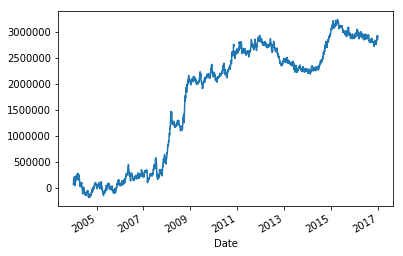

In [18]:
df['totalrunningpnl'].plot()
plt.show()

And the Sharpe ratio:

In [19]:
df['totalpnl'].mean()/df['totalpnl'].std()*math.sqrt(252)

0.6243438211650152